In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

<h2>Resize of Images </h2>

In [20]:
import numpy as np
import cv2
import os

def get_training_data(data_dir):
    data = []
    
    for category in os.listdir(data_dir):  
        path = os.path.join(data_dir, category)
        
        if not os.path.isdir(path):  # Skip files like .DS_Store
            continue  
        
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            
            # Ensure it's an image file
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            
            image = cv2.imread(img_path)
            if image is None:
                print(f"Error loading image: {img_path}")
                continue  # Skip corrupted images
            
            image = cv2.resize(image, (150, 150))  # Resize to a fixed size
            label = 0 if category == "NORMAL" else 1  # Assign labels
            data.append([image, label])  
    
    return np.array(data, dtype=object)  # Use dtype=object to handle lists

train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')


<h2>Preparing the training and testing data</h2>

In [21]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 1341
Normal: 3875
Pneumonia - Normal: -2534


<h2 >Incoprating the validation data into the training data  </h2>

In [22]:
X = []
y = []

for dataset in [train, test, val]:
    for item in dataset:
        if len(item) != 2:
            print(f"Unexpected item format: {item}")  # Debugging
            continue

        feature, label = item
        if feature.shape != (150, 150, 3):  # Check image shape
            print(f"Skipping invalid image with shape: {feature.shape}")
            continue

        X.append(feature)
        y.append(label)

X = np.array(X).reshape(-1, 150, 150, 3)  # Reshape to (num_samples, 150, 150, 3)
y = np.array(y)

print(f"Final X shape: {X.shape}, y shape: {y.shape}")


Final X shape: (5856, 150, 150, 3), y shape: (5856,)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)


In [24]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

Data augmentation 

In [25]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

<h2 >CNN (Convolutional Neural Network) </h2>


In [26]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 150, 150, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 75, 75, 256)         │             300 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 64)          │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 38, 38, 64)          │             152 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 38, 38, 16)          │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 38, 38, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 19, 19, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 19, 19, 16)          │              76 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5776)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5776)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         369,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,241 (2.04 MB)

 Trainable params: 533,977 (2.04 MB)

 Non-trainable params: 264 (1.03 KB)

In [28]:
model.evaluate(X_test, y_test)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - acc: 0.7153 - loss: 0.6836


[0.6832937002182007, 0.7218430042266846]

In [30]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - acc: 0.8713 - loss: 0.3192 - val_acc: 0.8602 - val_loss: 0.2921
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - acc: 0.8614 - loss: 0.3311 - val_acc: 0.9039 - val_loss: 0.2430
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - acc: 0.8599 - loss: 0.3219 - val_acc: 0.9157 - val_loss: 0.2294
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - acc: 0.8699 - loss: 0.3164 - val_acc: 0.9018 - val_loss: 0.2503
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - acc: 0.8748 - loss: 0.2956 - val_acc: 0.8602 - val_loss: 0.3244
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - acc: 0.8865 - loss: 0.2752 - val_acc: 0.8474 - val_loss: 0.3513


<h2>Visualizing our training progress</h2>

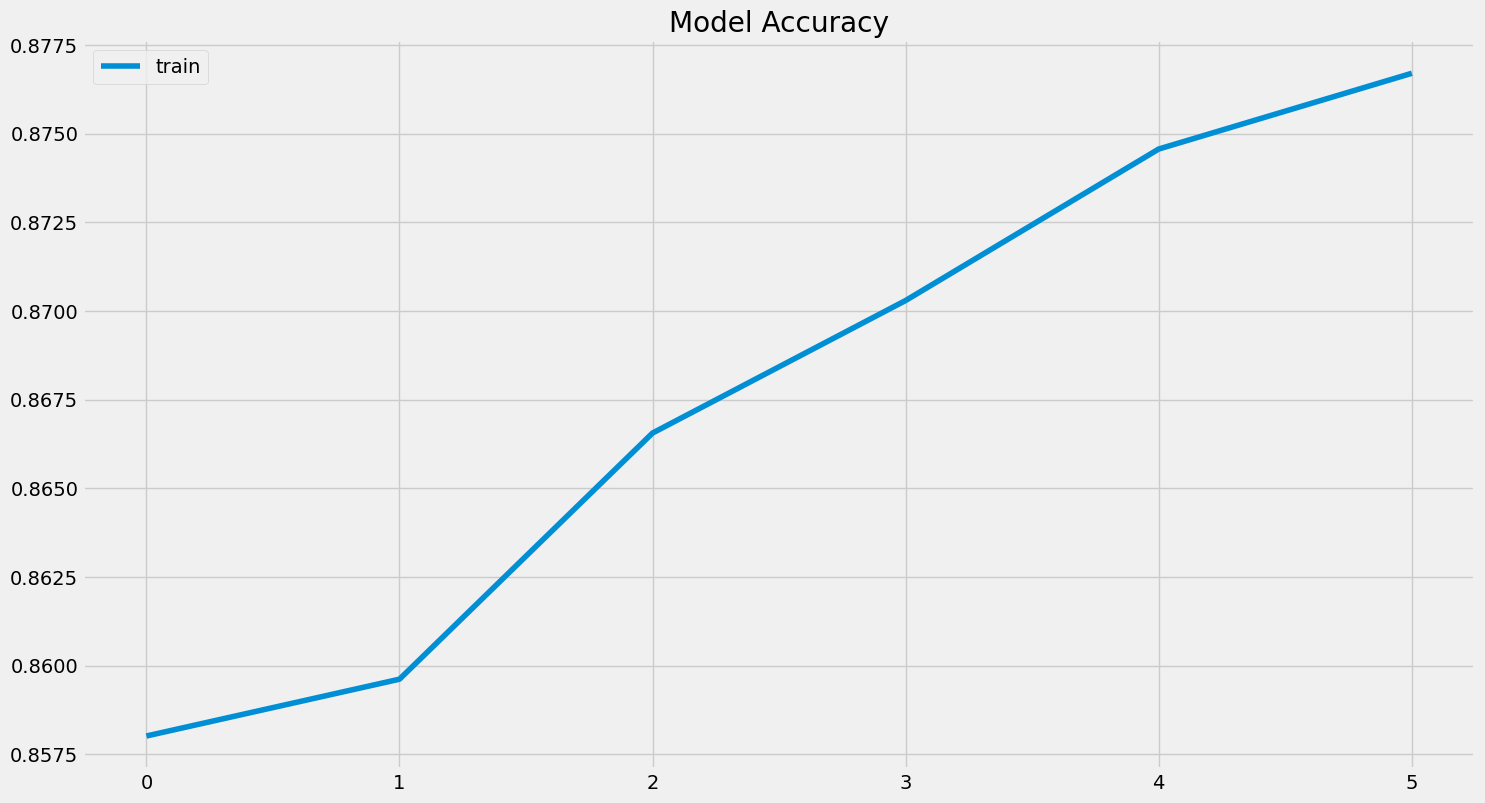

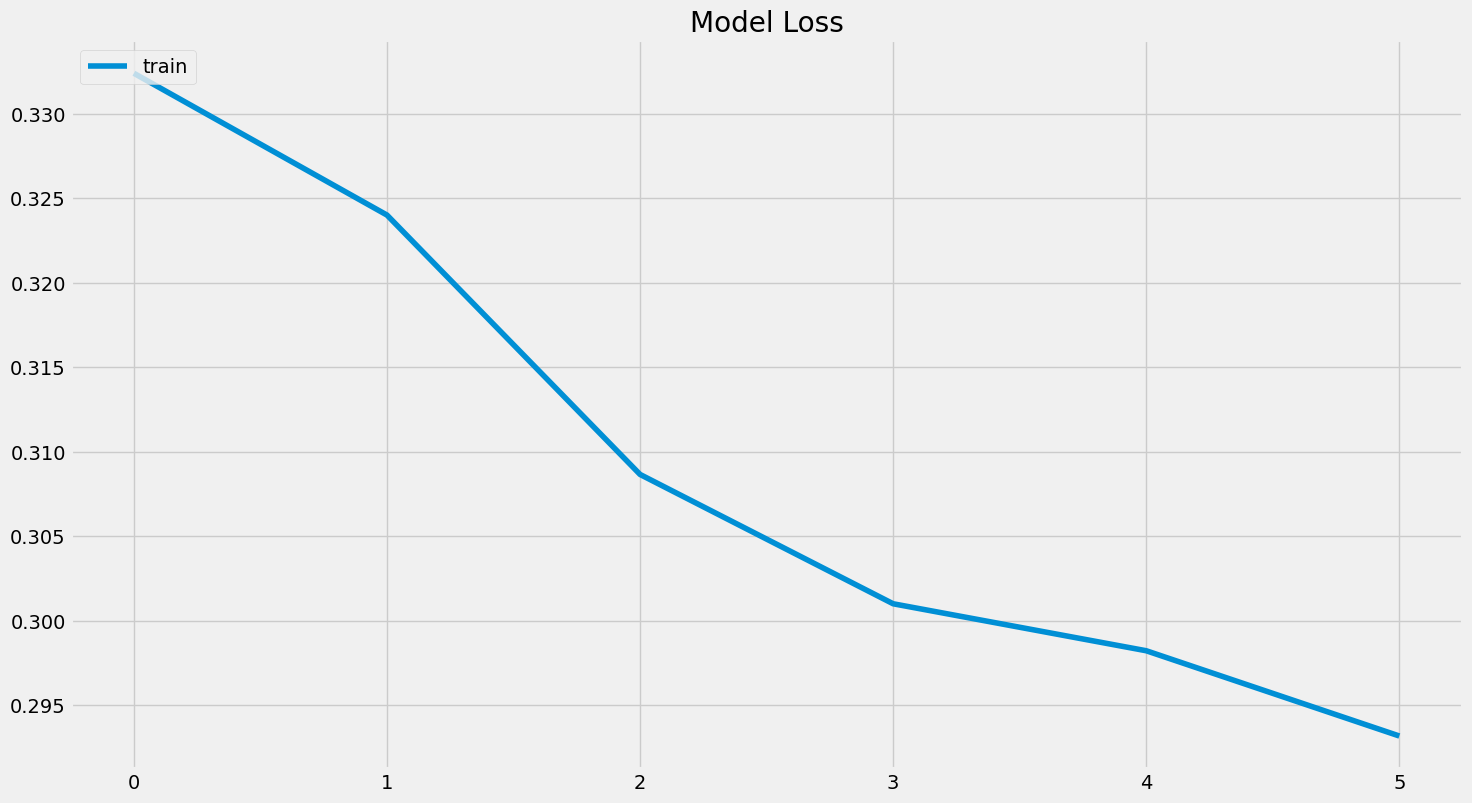

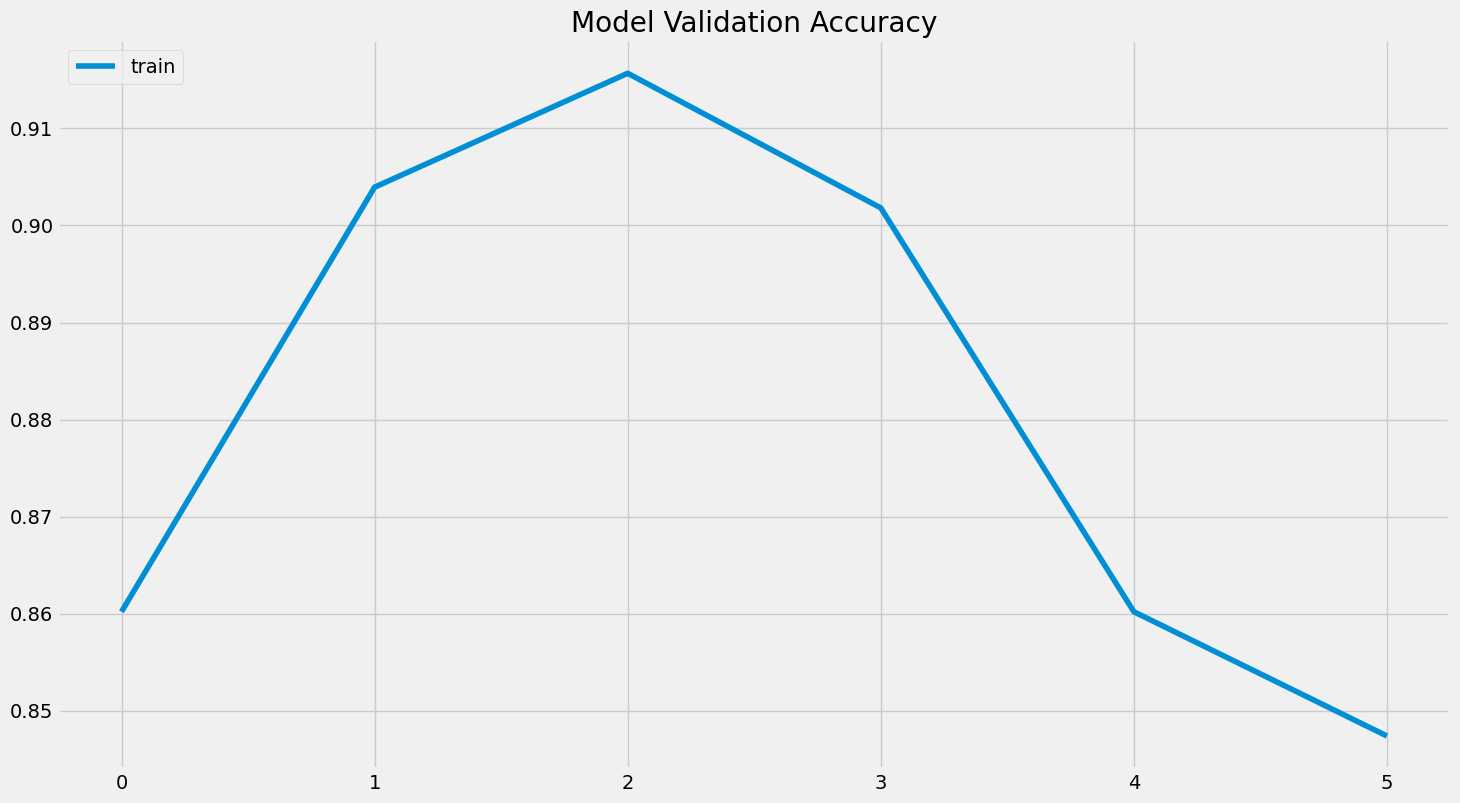

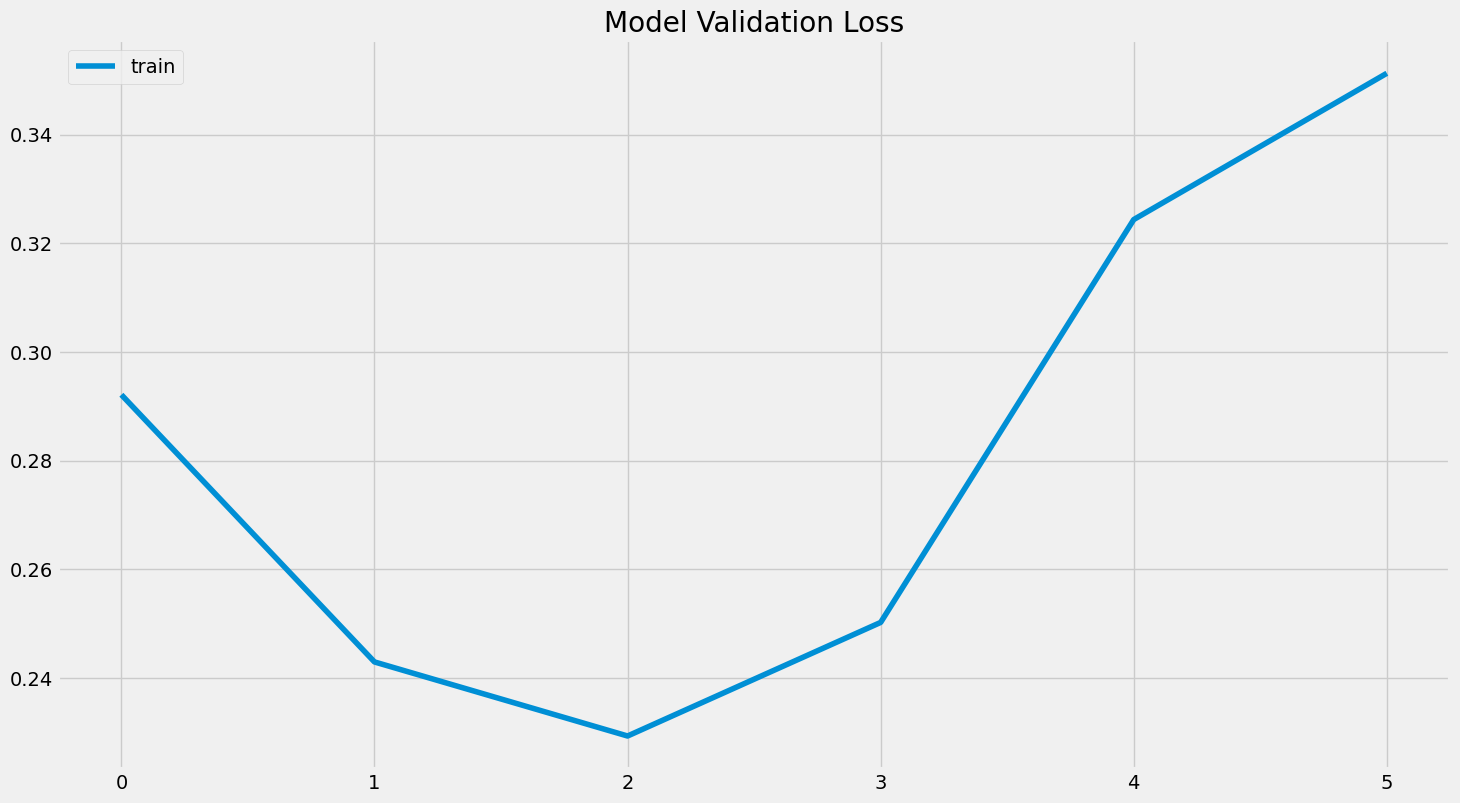

In [31]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

<h2>Prepare data for precision vs. recall and ROC</h2>

In [32]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


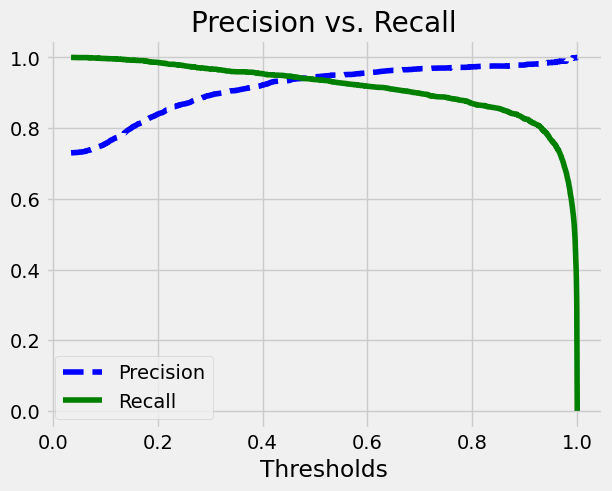

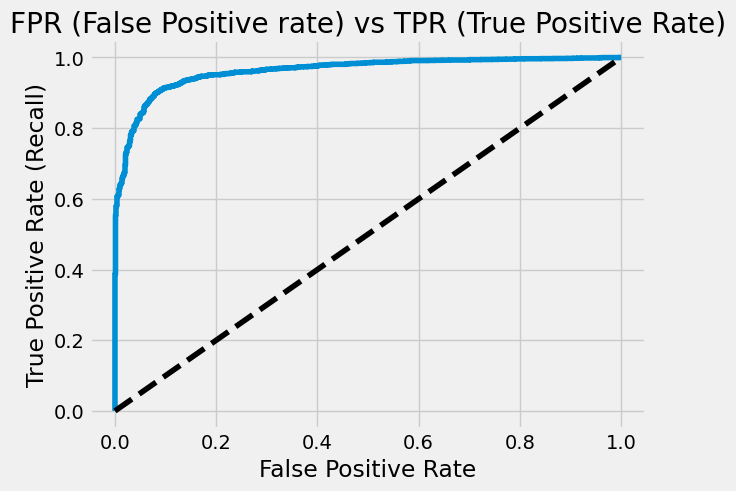

In [33]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [34]:
predictions = model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


<h2>Set thresholds for our model, we want the results to be precise while not sacraficing too much recall </h2>

In [35]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [36]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.8097269624573379
Precision on testing set: 0.9881376037959668
Recall on testing set: 0.7963671128107075


Text(0.5, 1.0, 'Confusion Matrix')

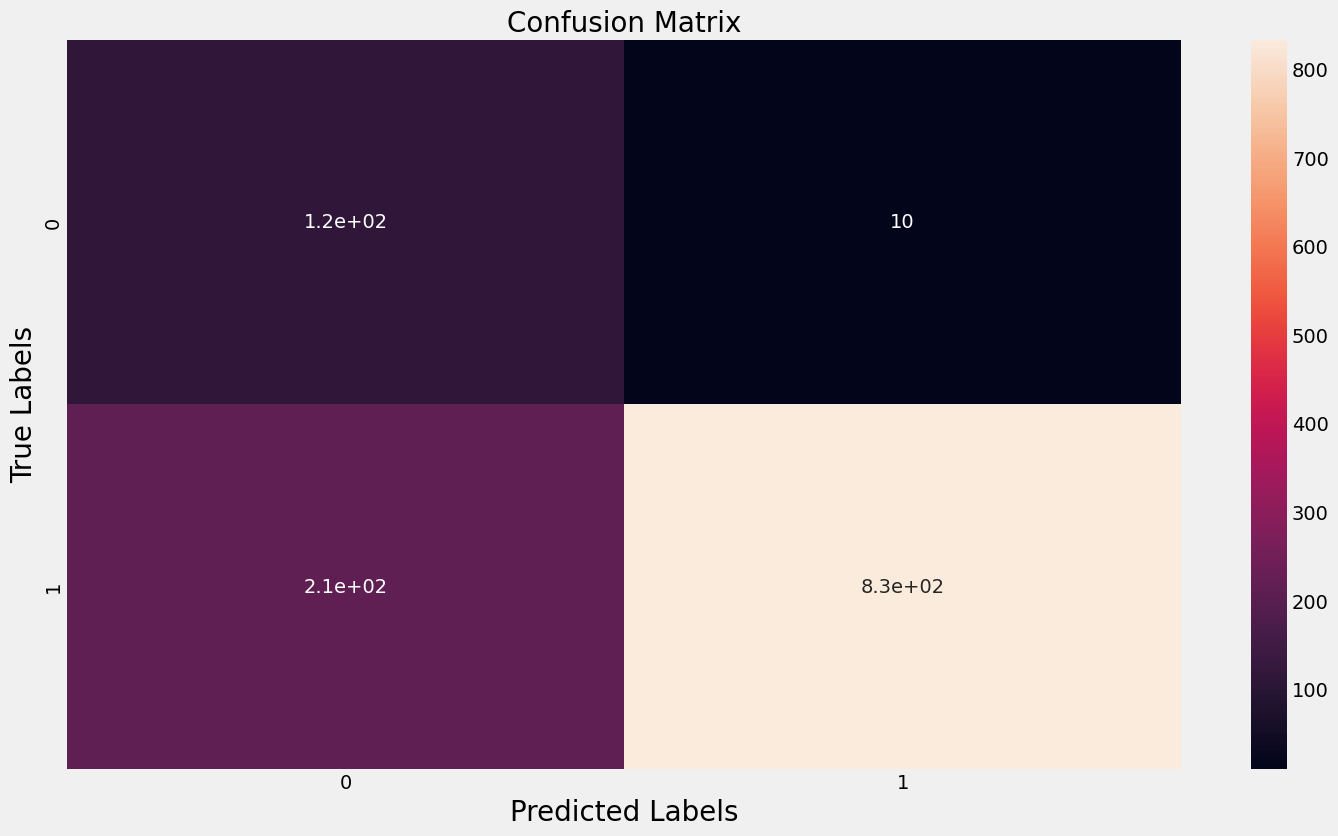

In [38]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 


<h2>View some results from a sample of 25 images</h2>

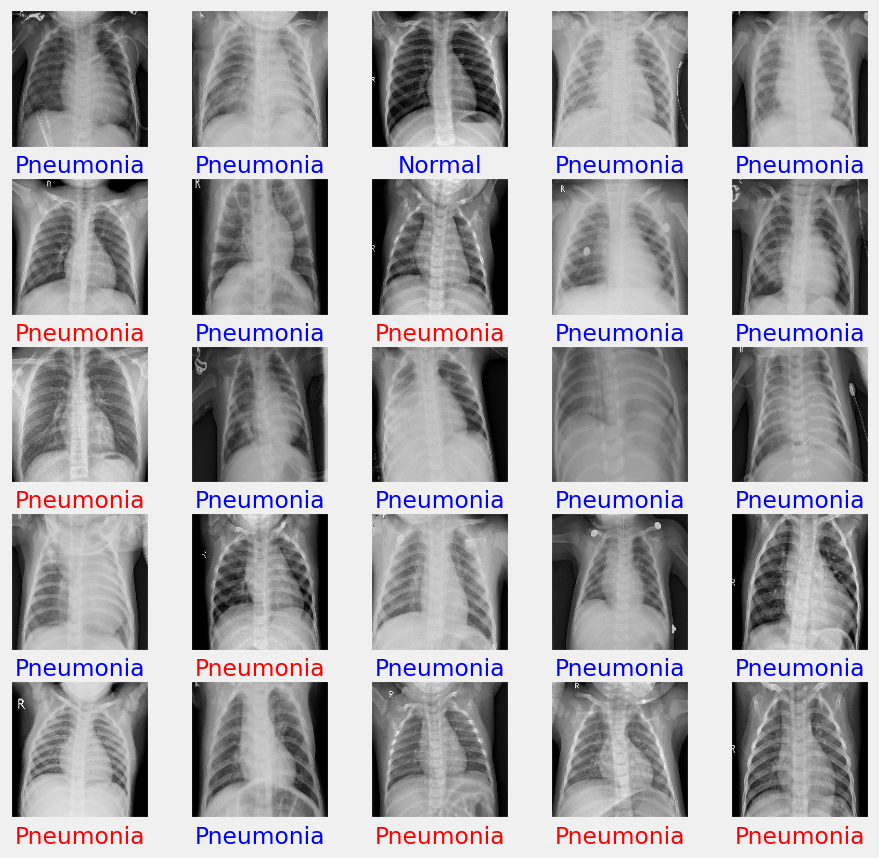

In [43]:
# Define labels dictionary
labels = {0: "Normal", 1: "Pneumonia"}  # Adjust based on your dataset

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Ensure the image is properly reshaped
    plt.imshow(X_test[i].squeeze(), cmap='gray')  
    
    if binary_predictions[i] == y_test[i]:
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')

plt.show()


In [45]:
 model.save('pneumonia_detection_ai_version_3.h5')